# Cross-Validation mit Random Forest <br> (OroraTech - LST)

**Autor*in:** Julian Hausmann
**Copyright:** © 2025 Urbetho CF GmbH
**Lizenz:** Dieses Notebook steht unter der [CC BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en).

<div style="text-align: right"><i> Fortgeschritten </i></div>

Über seine eigene Konstellation aus Thermalsatelliten bietet OroraTech Daten zur globale Erdoberflächentemperatur (LST) an. Während ältere Thermalsensoren wie ASTER, LANDSAT oder MODIS geringe zeitliche Wiederholungsraten aufweisen, soll die Konstellation von OroraTech ab 2026 in einem zeitlichen Interval von 30 Minuten globale LST liefern. Der Tasking-Mode erlaubt zudem zielgerichtete LST-Aufnahmen, die bei Waldbrandgefahr innerhalb von 3 Minuten Aufnahmen liefern sollen. EOLab bietet neben globalen Archivdaten mit einem Schwerpunkt auf Mitteleuropa bereits heute ein eigenes Nutzer-Tasking für individuelle Szenen an. Mit dem Zugang zu Daten der OroraTech Konstellation wird es Forschern auf EOLab ermöglicht Umweltprobleme wie Waldbrände oder städtischen Wärmeinseln noch besser zu verstehen und zu deren Bewältigung zu forschen. 

In diesem Notebook werden OroraTech's LST Daten für die Kartierung des Lake Barino Feuchtgebiet im Westen Kenias verwendet. Das Feuchtgebiet gilt als besonders Schützenswert auf Grund seiner herausragenden Rolle für die Versorgung der lokalen Bevölkerung als auch seinen Beitrag zur CO2-Speicherung. Es ist das größte Kenias und wird in der [Liste der Ramsar Feuchtgebiete](https://www.ramsar.org/sites/default/files/2023-08/sitelist.pdf) mit 31.469 ha beschrieben. Die Größe von Feuchtgebieten zu bestimmen ist wichtig, um die besonders schützenswerten Bereiche zu identifizieren. Es gilt jedoch als schwierig auf Grund ihrer Dynamik müssen exakte Größenangaben kritisch betrachtet werden. Die LST Daten von OroraTech könnten in Zukunft dabei helfen die Dynamik des Lake Baringo Feuchtgebiet zu überwachen und seiner Dynamik gerecht zu werden. In den folgenden Zellen werden wir die Daten nutzen, um zunächst für einen Zeitpunkt mithilfe einer Cross-Validation mit Random Forest unterschiedliche Landbedeckungsklassen zu bestimmen. Zusätzlich werden wir das auf CODE-DE vorhandene Copernicus DEM (GLO-30) verwenden, um Geländehöhe und -neigung zu ermitteln und als weitere Features für unsere Klassifikation zu nutzen. Für eine kontinuierliche Überwachung der Dynamik des Feuchtgebiet kann das DEM jedoch nicht verwendet werden, da es nur einmalig aufgenommen wurde. Am Ende des Notebooks werden wir die Wichtigkeit der Features bestimmen und damit testen, welche Bedeutung die LST für die Bestimmung der verschiedenen Klassen hatte. Als Trainings- und Validierungsdatensatz dienen uns Punktdaten, die während einem Feldaufenthalt des [WetlandHealth4UNgoelas-Projekt](https://www.zfl.uni-bonn.de/research/projects/wetlandhealth) im Frühjahr 2025 aufgenommen wurden.

Zugriff zu den Daten erhalten wir über eine **Virtuelle Maschine (VM)**. Wie Sie den Zugang zu einer VM erhalten lesen Sie im [**EO-LAB Portfolio**](https://eo-lab.org/de/portfolio/) unter dem Eintrag Virtuelle Maschinen. Der Zugang beschleunigt die Arbeit mit den Daten, da langwierige Downloads wegfallen. **Das Notebook kann auch für andere Feuchtgebiete ausprobiert werden. Dabei müssen nur an wenigen Stellen im Skript Änderungen vorgenommen werden. Entscheidende Stellen sind dabei die Definition des Ausschnitts, die Auswahl der LST Szene sowie das Einladen der Trainingsdaten. Viele Stellen bleiben komplett gleich - das Skript ist entsprechend automatisiert.**

**General Note 1**: Ausführung der Zellen durch pressen des <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button vom top MENU (oder `Shift` + `Enter`).

**General Note 2**: Falls der Kern nich mehr arbeitet, im the top MENU, klicke <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Dann, im top MENU, clicke  "Run" aund wähle "Run All Above Selected Cell".

**General Note 3**: Schauen Sie sich im [**FORUM**](https://forum.code-de.org/de/) um oder Kontaktieren Sie den Support! 
<br>

<img src="https://www.zfl.uni-bonn.de/research/projects/wetlandhealth/wetlands.jpeg/@@images/image/leadimagesize">

*In der Abbildung sehen Sie Impressionen des Lake Baringo Feuchtgebiet in Kenia. Das Feuchtgebiet hat eine große Bedeutung sowohl für die Versorgung der lokalen Bevölkerung als auch für die globale Speicherung von CO2. Um das Gebiet langfristig zu bewahren gilt es besonders schützenswerte Bereiche zu identifizieren. Die Abbildung stammt von [Tatenda Chiuya](https://www.zfl.uni-bonn.de/research/projects/wetlandhealth) und kann unter Namensnennung weiterverwendet werden.*

#### 1. Installieren der benötigten Bibliotheken

Verschiedene Pakete müssen installiert werden, bevor Zugriff und Analyse der Daten gestartet werden können. Die Liste der zu installierenden Bibliotheken ist abhängig von den bereits lokal installierten Bibliotheken und muss dementsprechend erweitert werden, falls Bedarf besteht. 

In [57]:
!pip install --quiet folium

#### 2. Importieren der benötigten Bibliotheken

Viele der unten genannten Bibliotheken mussten nicht installiert werden, weil sie entweder bereits installiert wurden oder zu einer generellen Installation von Python zugehörig sind. Ohne die Bibliotheken ist das folgende Skript nicht ausführbar.

In [58]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.io import MemoryFile
from collections import Counter
import folium
import os
import getpass
import requests
import math

#### 3. Definieren des Ausschnitt

Das Lake Baringo Feuchtgebiet wird in der [Liste der Ramsar Feuchtgebiete](https://www.ramsar.org/sites/default/files/2023-08/sitelist.pdf) mit den Koordinaten 00°36'N 36°04'E angegeben. Wir errechnen uns in der folgenden Zelle einen rechteckigen Ausschnitt um den Punkt herum. Aus eigener Recherche über Google Maps wissen wir, dass der See und das Feuchtgebiet sich weiter über die Länge als die Breite ausdehnen mit einem Faktor 2x. Deswegen verwenden wir für die Höhe (Nord-Süd) ±0.3°, Breite (Ost-West) ±0.15°. **Wenn ein anderes Feuchtgebiet untersucht werden soll, muss hier der Zentralpunkt ausgetauscht werden. Dabei kann man sich an den Koordinaten aus der [Liste der Ramsar Feuchtgebiete](https://www.ramsar.org/sites/default/files/2023-08/sitelist.pdf) orientieren.**

In [59]:
# Zentralpunkt in Dezimalgrad
center_lat = 0.6
center_lon = 36.0667

# Ausschnitt: Höhe (Nord-Süd) ±0.3°, Breite (Ost-West) ±0.15°
lat_buffer = 0.3
lon_buffer = 0.15

# Berechnen des Ausschnitt
extent = (
    center_lon - lon_buffer,  # xmin
    center_lat - lat_buffer,  # ymin
    center_lon + lon_buffer,  # xmax
    center_lat + lat_buffer   # ymax
)

# Ausgabe des berechneten Ausschnitt
print("Berechneter Ausschnitt:", extent)

Berechneter Ausschnitt: (35.9167, 0.3, 36.216699999999996, 0.8999999999999999)


#### 4. Öffnen der LST Szene

Um die passende LST Szene zu finden, durchsuchen wir das Dateiensystem unserer VM. Wichtig ist hierbei, dass wir das Verzeichnis mit den Thermaldaten in unserer VM gemountet haben. Hierbei ist eine Nutzeranfrage notwendig. Hierzu erhalten Sie Informationen im [EO-LAB Portfolio](https://eo-lab.org/de/portfolio/?id=537851c8-7592-4a12-b392-d52b08b32563). Das Mounten von Daten wird im folgenden [Knowledge Base](https://knowledgebase.eo-lab.org/en/latest/eodata/How-to-mount-eodata-using-S3FS-in-Linux-on-EO-Lab.html) Artikel beschrieben. Da es sich in dem Knowledge Base Artikel um das Mounten von EODATA handelt, müssen beim Mounten von constellr Daten andere Credentials und ein anderer Zusatz zum fstab file genutzt werden.

Der Genehmigungsablauf findet folgendermaßen statt:

<ol> 
<li>Füllen Sie dieses <a href="https://survey.hifis.dkfz.de/555711?lang=de-easy" target="_blank">Online-Formular</a> aus, um Ihr Projekt zu beschreiben; es ist erforderlich, um Ihren Antrag zu prüfen.</li> 
<li>Laden Sie das Formular herunter und speichern Sie es als PDF auf Ihrem Computer.</li> 
<li>Gehen Sie zum <a href="https://tenant-manager.eo-lab.org/panel/profile/personal" target="_blank">EO-Lab Tenant Manager</a>, melden Sie sich an.</li> 
<li>Stellen Sie sicher, dass Ihr Benutzerprofil einer „Organisation“ zugeordnet ist. Um dies zu überprüfen, navigieren Sie zu „Konfiguration“ und „Organisation“. <strong>WICHTIG:</strong> Bevor Sie eine neue Organisation anlegen, prüfen Sie bitte, ob für Ihren Arbeitgeber oder Ihr Projekt bereits eine Organisation angelegt wurde. Bitte wenden Sie sich an den Administrator / Projektverantwortlichen Ihres EO-Lab. Im Zweifelsfall senden Sie uns dazu bitte vorab eine Support-Anfrage!</li> 
<li>Nach der Zuweisung (oder Erstellung) einer Organisation erscheint im Menü links unter „Support“ ein neuer Punkt „Datenanfrage“. Erstellen Sie eine „Datenanfrage“ (im Menü auf der linken Seite) für das „EO-Lab Thermaldaten Archiv“. Fügen Sie das in Schritt 2 heruntergeladene Formular-PDF bei und reichen Sie Ihren Antrag ein. Sie werden nach der Auswertung benachrichtigt.</li> 
</ol>

Es ist hilfreich die LST Szenen über eine leaflet Karte anzeigen zu lassen. Dadurch können wir visuell direkt diejenigen Szenen bestimmen, die das Lake Baringo Feuchtgebiet beinhalten. Es gibt insgesamt zwei Szenen, die das Feuchtgebiet vollständig beinhalten. Beide Szenen sind zu ähnlichen Zeitpunkten erstellt worden - wir entscheiden uns für die jüngere Szene der beiden.

In [60]:
# Verzeichnis mit den .tif-Dateien
tif_directory = "/thermal-data-OroraTech/data/"

# Erstellen einer Karte mit Folium
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Durchlaufen aller Dateien im Verzeichnis
for filename in os.listdir(tif_directory):
    if filename.endswith('.tif'):
        if "_cloudmask" in filename:
            continue
        else:
            filepath = os.path.join(tif_directory, filename)
            with rasterio.open(filepath) as src:
                bounds = src.bounds
                rectangle = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

                folium.Rectangle(
                    bounds=rectangle,
                    color='blue',
                    fill=True,
                    fill_color='blue',
                    fill_opacity=0.2,
                    popup=filename
                ).add_to(m)


# Roter Rahmen für den Ausschnitt hinzufügen
folium.Rectangle(
    bounds=[[extent[1], extent[0]], [extent[3], extent[2]]],  # [[ymin, xmin], [ymax, xmax]]
    color='red',
    weight=3,
    fill=False,
    popup="Lake Baringo Feuchtgebiet"
).add_to(m)

# Anzeigen der Karte
m

Wir klicken die blauen Kacheln an und erhalten den Namen der LST Szene. Diesen kopieren wir anschließend in den nächsten Code Abschnitt. Neben der LST Szene öffnen wir auch die Wolkenmaske. Wir nutzen sie anschließend, um alle LST-Pixel zu exkludieren, die mit einer hohen Wahrscheinlichkeit von Wolken bedeckt sind. **Wenn ein anderes Feuchtgebiet untersucht werden soll, muss entsprechend ein anderer Name für den lst_path und lst_cldmask_path kopiert werden.**

In [61]:
from rasterio.windows import from_bounds

# Dateipfade der LST Szene und ihrer Wolkenmaske
lst_path = "/thermal-data-OroraTech/data/F002_L2_LST_20241216T231345_20241218T134923_ee5d0ef98ddc095ce79fdd7c51a890e6a3a23e2434e43feb50015072703f489c.tif"
lst_cldmask_path = "/thermal-data-OroraTech/data/F002_L2_LST_20241216T231345_20241218T134923_ee5d0ef98ddc095ce79fdd7c51a890e6a3a23e2434e43feb50015072703f489c_cloudmask.tif"

# Öffnen der LST Szene
with rasterio.open(lst_path) as src:
    transform = src.transform
    lst_crs = src.crs
    lst_height = src.height
    lst_width = src.width

    win = from_bounds(
        extent[0], extent[1], extent[2], extent[3],
        transform
    )
    lst = src.read(1, window=win) - 273.15

# Öffnen der Wolkenmaske
with rasterio.open(lst_cldmask_path) as src:
    cld = src.read(1, window=win)

# Anwenden der Wolkenmaske auf die LST Szene
cloud_mask = cld == 1
lst = np.where(cloud_mask, np.nan, lst)


#### 5. Öffnen der DEM Szene

Das Copernicus DEM (GLO-30) ist auf der Virtuellen Maschine unter dem codede-Verzeichnis zu finden: */codede/auxdata/CopDEM/COP-DEM_GLO-30-DGED/*. Um genau herauszufinden, welchen Ausschnitt wir benötigen, führen wir eine Abfrage über die EO-LAB Katalog-API durch. Um sich einen visuellen Eindruck vom den Daten der API zu machen, kann der [EO-Lab Explorer](https://explore.eo-lab.org/search?) oder [CODE-DE Explorer](https://explore.code-de.org/search?) verwendet werden. Über die Katalog-API können die Daten von beiden Explorern gefiltert werden, um passende Satellitenaufnahmen zu finden. Über die verschiedenen Standards Odata, Resto OPen Search und STAC können die Daten auch gedownloaded werden. In unserem Fall ist das nicht nötig, alle Daten liegen uns lokal auf unserer VM vor. Über die Katalog-API werden wir also lediglich die S3-Pfade filtern, die uns zu den DEM Ausschnitten auf unserer VM führen. 

Um den Katalog zu durchsuchen benötigen wir keine Zugangsdaten. Wir definieren also nur unsere API-URL über den zuvor errechneten Ausschnitt des Lake Baringo Feuchtgebietes. Anschließend ziehen wir uns die Footprints der DEM Ausschnitte aus den Metadaten und lassen sie uns auf einer Karten darstellen. Dadurch können wir erkennen, dass das Feuchtgebiet nicht nur von einem Ausschnitt abgedeckt wird und wir zwei Aufnahmen zu einem Komposit für die spätere Analyse zusammenfügen müssen. Dafür lassen wir uns die kompletten S3-Pfade anzeigen, die wir gleich nutzen werden für die weitere Arbeit mit den DEM Ausschnitten. 

In [62]:
# Entpacken des Ausschnitt in xmin, ymin, xmax, ymax
xmin, ymin, xmax, ymax = extent

# Erstellen der API-URL zur Abfrage von COP-DEM über EO-Lab Datahub
api_url = f"https://datahub.eo-lab.org/odata/v1/Products?$filter=((Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POLYGON%20(({xmin}%20{ymax},%20{xmax}%20{ymax},%20{xmax}%20{ymin},%20{xmin}%20{ymin},%20{xmin}%20{ymax}))%27))%20and%20(((((Collection/Name%20eq%20%27COP-DEM%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27DGE_30%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"

# API-Abfrage und Parsen der JSON-Antwort
response = requests.get(api_url)
data = response.json()

# Erstellen der Karte mit initialem Zoom auf den Zielbereich
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Produkte durchlaufen und Bounding Boxes als blaue Rechtecke auf der Karte zeichnen
for product in data['value']:
    name = product.get('Name', 'Unknown')
    geofootprint = product.get('GeoFootprint')
    if geofootprint:
        coordinates = geofootprint['coordinates'][0]  # Außenring des Polygons
        lats = [pt[1] for pt in coordinates]
        lons = [pt[0] for pt in coordinates]
        bounds = [[min(lats), min(lons)], [max(lats), max(lons)]]
        
        folium.Rectangle(
            bounds=bounds,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.2,
            popup=name
        ).add_to(m)

# Ausgeben verfügbarer DEM-Dateipfade, falls vorhanden
print("Verfügbare DEM (als S3-Pfad):")
dem_paths = []
for item in data['value']:
    s3_path = item['S3Path']
    files = os.listdir(s3_path)
    dem_folder = os.path.join(s3_path, files[0], "DEM")
    files_sub = os.listdir(dem_folder)
    full_path = os.path.join(dem_folder, files_sub[0])
    if "_PUBLIC" in full_path:
        continue
    else:
        print(full_path)
        dem_paths.append(full_path)

# Roter Rahmen für das Lake Baringo Wetland auf der Karte
folium.Rectangle(
    bounds=[[extent[1], extent[0]], [extent[3], extent[2]]],
    color='red',
    weight=3,
    fill=False,
    popup="Lake Baringo Feuchtgebiet"
).add_to(m)

# Karte anzeigen
m


Verfügbare DEM (als S3-Pfad):
/codede/auxdata/CopDEM/COP-DEM_GLO-30-DGED/DEM1_SAR_DGE_30_20101212T155531_20141004T154829_ADS_000000_3055.DEM/Copernicus_DSM_10_N00_00_E035_00/DEM/Copernicus_DSM_10_N00_00_E035_00_DEM.tif
/codede/auxdata/CopDEM/COP-DEM_GLO-30-DGED/DEM1_SAR_DGE_30_20110318T032119_20141130T032137_ADS_000000_3093.DEM/Copernicus_DSM_10_N00_00_E036_00/DEM/Copernicus_DSM_10_N00_00_E036_00_DEM.tif


Im folgenden Abschnitt werden die beiden S3-Pfade genutzt. Nach dem Erstellen des gemeinsamen Komposit, schneiden wir es auf den bereits errechneten Ausschnitt des Lake Baringo Feuchtgebiet zurrecht. Außerdem errechnen wir die Hangneigungen. Sie sind ein wichtiger Indikator für den Oberflächenabfluss und werden bei der späteren Klassifizierung ein wichtiger Indikator dafür sein, ob es sich um Feuchtgebiet handelt oder nicht.  

In [63]:
from rasterio.windows import from_bounds

# DEM öffnen und ggf. mergen
if len(dem_paths) == 1:
    # Nur ein Tile, kein Merge notwendig
    with rasterio.open(dem_paths[0]) as dem_src:
        dem_transform = dem_src.transform
        dem_crs = dem_src.crs
        
        dem_window = from_bounds(*extent, transform=dem_transform)
        dem = dem_src.read(1, window=dem_window)

else:
    # Mehrere Tiles, Mergen notwendig
    dem_srcs = [rasterio.open(path) for path in dem_paths]
    dem_array, dem_transform = merge(dem_srcs)
    dem_crs = dem_srcs[0].crs  # Annahme: alle haben gleiche CRS
    for src in dem_srcs:
        src.close()
    
    dem = dem_array[0]
    dem_window = from_bounds(*extent, transform=dem_transform)
    
    with MemoryFile() as memfile:
        with memfile.open(
            driver='GTiff',
            height=dem.shape[0],
            width=dem.shape[1],
            count=1,
            dtype=dem.dtype,
            transform=dem_transform,
            crs=dem_crs,
        ) as dataset:
            dataset.write(dem, 1)
            dem = dataset.read(1, window=dem_window)

# Funktion zur Berechnung der Hangneigung aus einem DEM
def calculate_slope(dem_array, transform, crs):
    xres = transform.a
    yres = -transform.e  # transform.e ist negativ, daher umkehren

    if crs.is_geographic:
        xres *= 111320
        yres *= 110540

    dzdx = np.gradient(dem_array, axis=1) / xres
    dzdy = np.gradient(dem_array, axis=0) / yres

    slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
    slope_deg = np.degrees(slope_rad)
    return slope_deg

# Berechnung der Hangneigung aus dem DEM
slope = calculate_slope(dem, dem_transform, dem_crs)


#### 6. Resampling

Da das DEM eine höhere räumliche Auflösung (30 m) besitzt als die LST-Daten (200 m), enthält es feinere Details und Variabilität, die die LST-Daten aufgrund ihrer gröberen Auflösung nicht abbilden können. Um beide Datensätze direkt vergleichen oder in Regressionsmodellen verwenden zu können, müssen sie dieselbe Auflösung haben. Ein Downsampling erscheint in diesem Fall sinnvoll, da das LST den Datensatz mit der limitierenden Auflösung darstellt und ein Upsampling nur zu einer Scheingenauigkeit basierend auf interpolierten Schätzungen führen würde. Insgesamt wird für die weitere Analyse durch das Downsampling auch der Rechenaufwand und Speicherbedarf reduziert.

In [64]:
# Funktion für das Resampling
def resample(target_grid: np.ndarray, initial_grid: np.ndarray) -> np.ndarray:
    
    # Zielgröße ermitteln
    target_shape = target_grid.shape

    # Normalisierte Koordinaten für das Initialraster erzeugen
    x = np.linspace(0, 1, initial_grid.shape[1])
    y = np.linspace(0, 1, initial_grid.shape[0])
    x_grid, y_grid = np.meshgrid(x, y)
    points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
    values = initial_grid.ravel()

    # Normalisierte Koordinaten für das Zielraster erzeugen
    x_target = np.linspace(0, 1, target_shape[1])
    y_target = np.linspace(0, 1, target_shape[0])
    x_target_grid, y_target_grid = np.meshgrid(x_target, y_target)
    target_points = np.column_stack((x_target_grid.ravel(), y_target_grid.ravel()))

    # Resampling mittels nearest neighbor Interpolation
    resampled_grid = griddata(points, values, target_points, method='nearest')
    resampled_grid = resampled_grid.reshape(target_shape)

    # Prüfung der Form des resampleten Rasters
    assert resampled_grid.shape == target_grid.shape, "Erfolgreiches Resampling der Raster."
    return resampled_grid

# Resampling des DEM auf das Raster der LST-Daten
dem_resampled = resample(target_grid=lst, initial_grid=dem)

# Anwenden der Wolkenmaske auf die DEM Szene
dem_resampled = np.where(cloud_mask, np.nan, dem_resampled)

# Resampling des berechneten Hangneigungsrasters auf LST-Raster
slope_resampled = resample(target_grid=lst, initial_grid=slope)

# Anwenden der Wolkenmaske auf die Slope Szene
slope_resampled = np.where(cloud_mask, np.nan, slope_resampled)


#### 7. Laden der Trainingspunkte

Die Cross-Validation, die wir später auf der Grundlage von Random Forest durchführen werden, gehört zu den *Supervised Learning* Methoden. Dafür benötigen wir beschriftete Trainingsdaten, die Informationen über die Landbedeckung enthalten. Wir verwenden dafür Daten, die im Zuge eines Feldaufenthalts des [WetlandHealth4UNgoelas-Projekt](https://www.zfl.uni-bonn.de/research/projects/wetlandhealth) im Frühjahr 2025 aufgenommen wurden. Die Daten stehen bei Nennung des Projekts frei zur Verfügung. Zwischen der LST Aufnahme und dem Sammeln der Daten liegen mehrere Monate. Für eine bessere Peformance des Random Forest Ansatzes müssten Daten genutzt werden, mit einem kleineren zeitlichen Abstand. Hier standen diese jedoch leider nicht zur Verfügung. **Wenn ein anderes Feuchtgebiet untersucht werden soll, dann müssen andere Trainingsdaten verwendet werden. Die Daten müssen über eine Spalte mit dem Namen "class" verfügen mit den Labels "forest", "rangeland", "water" und "wetland". Die Trainingsdaten sind Punktdaten, die manuell auf der Basis von Felddaten aber auch Luftbildern (z. B. in QGIS) gesetzt werden können.**

In [65]:
# Pfad zur Shapefile mit Trainingspunkten
shapefile_path = "/zfl_data/02_git-repositories/training-materials/training-materials/in_progress_for_notebook-samples/baringo_training_points.shp"

# Shapefile als GeoDataFrame laden
gdf = gpd.read_file(shapefile_path)

# Koordinatensystem an LST-CRS anpassen, falls unterschiedlich
if gdf.crs != lst_crs:
    gdf = gdf.to_crs(lst_crs)

# Vorschau der Trainingspunkte (alle bis auf die letzten 10)
gdf.head(-10)

,id,class,geometry
0,1,water,POINT (36.06711 0.56802)
1,2,water,POINT (36.04937 0.67043)
2,3,water,POINT (36.09725 0.47869)
3,4,water,POINT (36.09869 0.47104)
4,5,water,POINT (36.07187 0.34713)
...,...,...,...
60,60,wetland,POINT (36.0458 0.36288)
61,61,wetland,POINT (36.04572 0.36396)
62,62,wetland,POINT (36.0472 0.36442)
63,63,wetland,POINT (36.04681 0.36795)


#### 7. Visualisieren der Input-Raster und der Trainingspunkte

Um einen ersten Eindruck von der räumlichen Verteilung der Features LST, DEM und Hangneigung zu erhalten, werden wir die Daten hier visualisieren. Außerdem werden die Trainingspunkte ergänzt, damit abgeschätzt werden kann, ob die Punkte das Gebiet gut repräsentieren und welche Features mit welchen Klassen zusammenhängen könnten. Es fällt bereits auf, dass es nicht gleichmäßig viele Trainingspunkte gibt, was zu einem Problem werden könnte, wenn es um die Performance der verschiedenen Klassen geht. Außerdem fällt auf, dass es vermutlich schwierig werden wird, rangeland von forest zu unterscheiden, da viele Ausprägungen ähnlich sind. Die Unterscheidung zwischen water und wetland wird auch schwieriger sein, da die Features recht ähnliche Ausprägungen zeigen. 

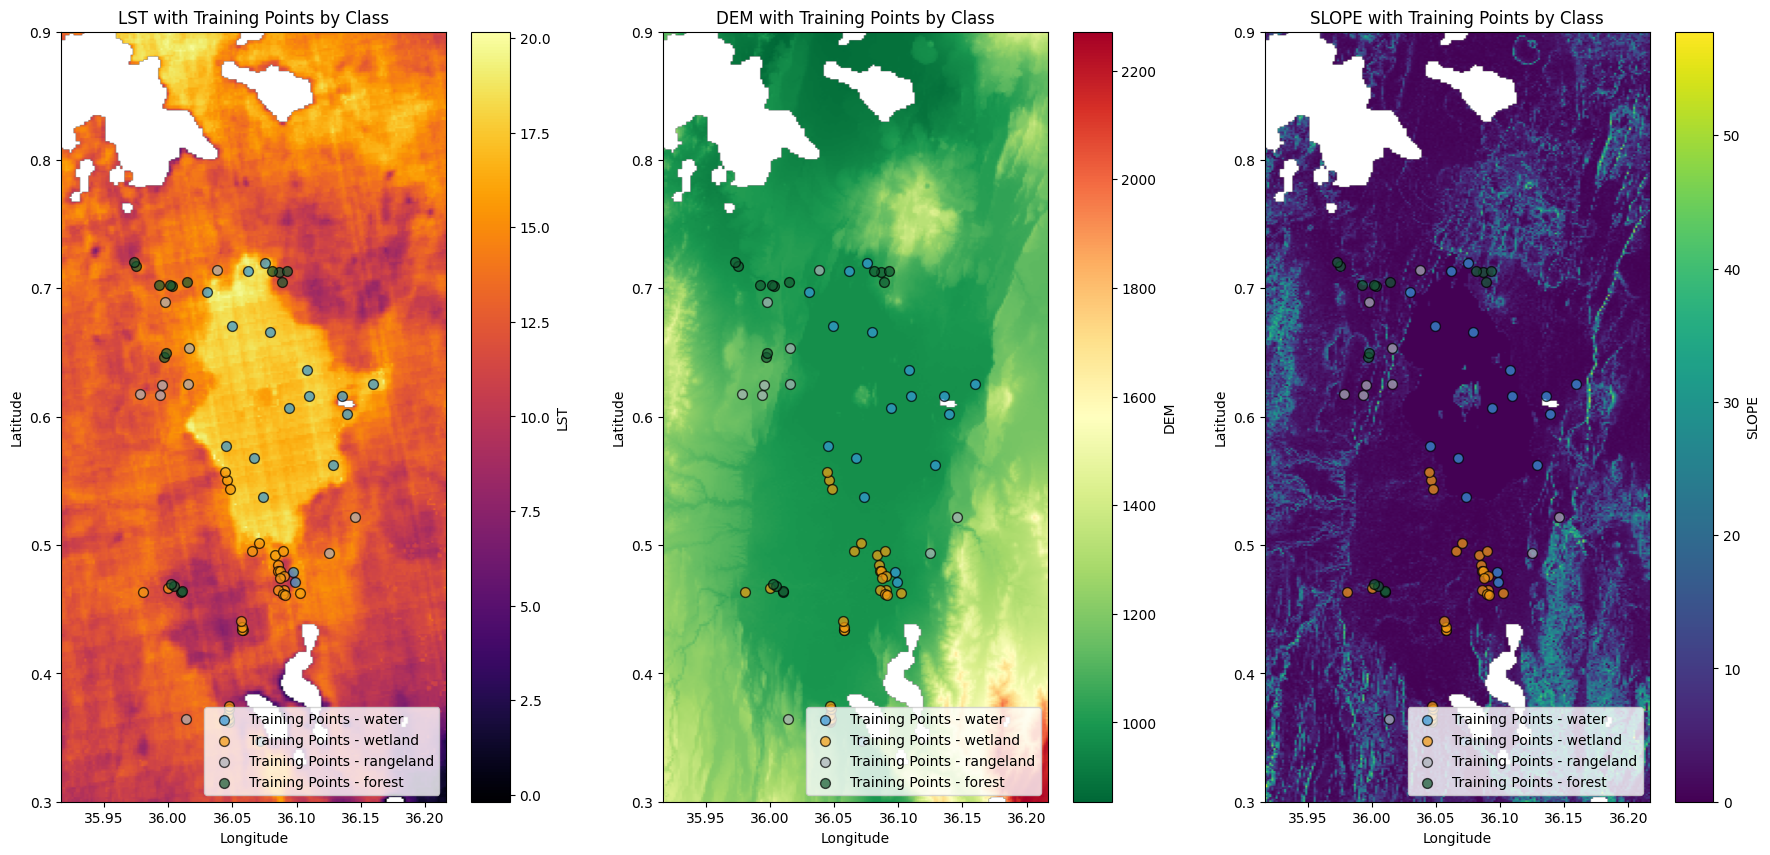

In [66]:
# Liste von Rasterdaten, ihren Namen und optionalen Colormaps
rasters = [
    (lst, "LST", "inferno"),
    (dem_resampled, "DEM", "RdYlGn_r"),
    (slope_resampled, "SLOPE", "viridis"),
]

# Erstellen einer Figure mit 3 Subplots nebeneinander
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 10))
axes = axes.flatten()

# Einzigartige Klassen aus den Trainingspunkten extrahieren
classes = gdf['class'].unique()
colors = [ '#3498db', '#f39c12', '#abb2b9', '#145a32']

# Für jeden Rasterlayer und Subplot
for i, (raster, title, *cmap) in enumerate(rasters):
    ax = axes[i]
    colormap = cmap[0] if cmap else 'gray'

    # Rasterbild anzeigen mit korrektem Extent und Colormap
    im = ax.imshow(
        raster,
        cmap=colormap,
        extent=[extent[0], extent[2], extent[1], extent[3]],
        origin='upper'
    )
    
    # Trainingspunkte pro Klasse als Scatterplot hinzufügen
    for cls, color in zip(classes, colors):
        subset = gdf[gdf['class'] == cls]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            color=color,
            s=50,
            edgecolor='black',
            label=f'Training Points - {cls}',
            alpha=0.7
        )
    
    # Farbskala hinzufügen und Achsen beschriften
    fig.colorbar(im, ax=ax, label=title)
    ax.set_title(f"{title} with Training Points by Class")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='lower right')
    ax.set_aspect('equal')

#### 9. Vorbereiten der Trainingsdaten

Im nächsten Schritt müssen zu den Trainingspunkten Werte der Features LST, DEM und Hangneigung extrahiert werden. Punkte, die nicht innerhalb der Raster liegen werden aussortiert. Außerdem werden die Klassen kodiert, sodass die Namen zu Nummern umgewandelt werden.

In [67]:
from rasterio.transform import rowcol, from_bounds

# Feature-Stack aus LST, resampletem DEM und resampletem Slope erstellen (3D-Array)
feature_stack = np.stack([lst, dem_resampled, slope_resampled], axis=-1)

# Koordinaten der Trainingspunkte extrahieren
coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]

# Raster-Indizes (Zeile, Spalte) für jede Koordinate berechnen
rows_cols = [rowcol(transform, x, y) for x, y in coords]

# Offsets des Fensters speichern (für späteren Zugriff)
row_off = win.row_off
col_off = win.col_off

train_pixels = []
train_labels = []

# Für jeden Punkt Koordinaten im Fenster berechnen und Werte extrahieren
for (row_full, col_full), label in zip(rows_cols, gdf["class"]):
    row_win = int(round(row_full - row_off))
    col_win = int(round(col_full - col_off))
    
    # Nur Punkte innerhalb des Fensters verwenden
    if 0 <= row_win < feature_stack.shape[0] and 0 <= col_win < feature_stack.shape[1]:
        pixel_vals = feature_stack[row_win, col_win, :]
        # Nur Pixel ohne NaN-Werte hinzufügen
        if not np.any(np.isnan(pixel_vals)):
            train_pixels.append(pixel_vals)
            train_labels.append(label)
    else:
        print(f"Punkt (row={row_full}, col={col_full}) außerhalb des Fensters")

# In numpy-Arrays umwandeln
train_pixels = np.array(train_pixels)
train_labels = np.array(train_labels)

# Anzahl der Trainingsbeispiele ausgeben
print(f"Training samples: {len(train_labels)}")
print("Classes in training:", dict(zip(*np.unique(train_labels, return_counts=True))))

# Labels in numerische Werte encodieren für ML-Modelle
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)

Training samples: 75
Classes in training: {np.str_('forest'): np.int64(16), np.str_('rangeland'): np.int64(10), np.str_('water'): np.int64(18), np.str_('wetland'): np.int64(31)}


#### 10. Stratifizierte 5-fach Cross-Validation mit Random Forest

Bei der stratifizierten 5-fach Cross-Validation wird der Datensatz mit den Trainingspunkten in fünf Teilmengen (Folds) aufgeteilt. Dabei wird sichergestellt, dass jede Teilmenge die Klassenverteilung des Gesamtdatensatzes widerspiegelt (Stratifizierung). In jedem der fünf Durchläufe wird ein Fold als Validierungsmenge verwendet, während die restlichen vier Folds zum Training des Random Forest Modells genutzt werden. Dadurch werden in jedem Durchlauf etwa zwei Drittel der Daten zum Trainieren und ein Drittel zur Validierung verwendet.

Aus den Ergebnissen der fünf einzelnen Validierungen wird anschließend eine Durchschnittsmatrix (z. B. Konfusionsmatrix) berechnet, die eine verlässliche Schätzung der Gesamtgenauigkeit und der Klassifikationsleistung des Modells ermöglicht.

Random Forest ist ein ensemble-basierter, überwachter Lernalgorithmus, der aus vielen Entscheidungsbäumen besteht. Jeder Baum wird auf einem zufällig ausgewählten Teil der Trainingsdaten und mit einer zufälligen Auswahl von Features trainiert. Die finale Vorhersage ergibt sich aus der Mehrheitsentscheidung der einzelnen Bäume. Diese Methode erhöht die Robustheit, reduziert Überanpassung (Overfitting) und verbessert die Genauigkeit im Vergleich zu einzelnen Entscheidungsbäumen.

In [68]:
# Stratified K-Fold Cross-Validation mit 5 Splits, zufällig gemischt
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fold = 1

all_true = []
all_pred = []

# Für jeden Fold: Trainings- und Testdaten aufteilen, Modell trainieren und bewerten
for train_index, test_index in skf.split(train_pixels, train_labels_encoded):
    X_train, X_test = train_pixels[train_index], train_pixels[test_index]
    y_train, y_test = train_labels_encoded[train_index], train_labels_encoded[test_index]

    # Random Forest Klassifikator mit 100 Bäumen trainieren
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Vorhersagen auf Testdaten
    y_pred = rf.predict(X_test)

    # Genauigkeit berechnen und speichern
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Ergebnisse für Gesamtauswertung speichern
    all_true.extend(y_test)
    all_pred.extend(y_pred)

    fold += 1

# Gesamte Genauigkeit über alle Folds ausgeben
print(f"Overall Accuracy: {accuracy_score(all_true, all_pred):.4f}")

# Detaillierter Klassifikationsbericht mit Precision, Recall, F1-Score
print(classification_report(all_true, all_pred, target_names=le.classes_))

# Konfusionsmatrix ausgeben
cm = confusion_matrix(all_true, all_pred)
print("Confusion Matrix:")
print(cm)

Overall Accuracy: 0.7733
              precision    recall  f1-score   support

      forest       0.65      0.69      0.67        16
   rangeland       0.57      0.40      0.47        10
       water       1.00      0.78      0.88        18
     wetland       0.78      0.94      0.85        31

    accuracy                           0.77        75
   macro avg       0.75      0.70      0.72        75
weighted avg       0.78      0.77      0.77        75

Confusion Matrix:
[[11  2  0  3]
 [ 5  4  0  1]
 [ 0  0 14  4]
 [ 1  1  0 29]]


#### 11. Anwendung der Klassifizierung auf das Gesamtbild

Nun wird ein neuer Random Forest Algorithmus auf der Basis aller Trainingspunkte trainiert. Er wird dann auf den Gesamtausschnitt des Lake Barinog Feuchtgebiet angewendet. Die Genauigkeit lässt sich jetzt nur schätzen, liegt aber in etwa beim Durchschnittswert, der zuvor bei der Cross-Validation errechnet wurde. Für die identifizierten Landbedeckungen werden außerdem die Flächen berechnet. Dafür muss zunächst die Pixelgröße errechnet werden. Zwar ist diese bei OroraTech mit 200m angegeben, sie kann jedoch variieren je nach Lage zum Äquator. Da wir fast am Äquator unseren Gebietsausschnitt haben, ist es wahrscheinlich, dass die Pixelwerte stark von den angegebenen 200m abweichen. 

In [69]:
# Finales Random Forest Modell trainieren mit allen Trainingsdaten
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(train_pixels, train_labels_encoded)

# Feature-Stack in 2D umformen (Pixelanzahl x Features)
flat_features = feature_stack.reshape(-1, feature_stack.shape[-1])

# Maske für gültige Pixel ohne NaN-Werte erstellen
valid_mask = ~np.any(np.isnan(flat_features), axis=1)

# Array für Vorhersagen initialisieren (-1 = no data / keine Klassifikation)
predicted_encoded = np.full(flat_features.shape[0], -1, dtype=int)

# Vorhersage nur für gültige Pixel durchführen
predicted_encoded[valid_mask] = rf_final.predict(flat_features[valid_mask])

# Vorhersagen zurück in Bildform bringen (2D)
predicted_img = predicted_encoded.reshape(feature_stack.shape[:2])

# Pixelanzahl pro Klasse zählen (ohne -1 = keine Klassifikation)
valid_mask = predicted_img >= 0
pixel_counts = Counter(predicted_img[valid_mask].flatten())

# Länge eines Breitengrads in Metern (fast konstant)
meter_per_deg_lat = 111320

# Länge eines Längengrads abhängig vom Breitengrad (cosinus-Korrektur)
meter_per_deg_lon = 111320 * math.cos(math.radians(center_lat))

# Pixelgröße in Grad (Extent geteilt durch Rasterdimension)
pixel_width_deg = abs(extent[2] - extent[0]) / predicted_img.shape[1]
pixel_height_deg = abs(extent[3] - extent[1]) / predicted_img.shape[0]

# Pixelgröße in Metern berechnen (Breitengrad-dynamisch)
pixel_width_m = pixel_width_deg * meter_per_deg_lon
pixel_height_m = pixel_height_deg * meter_per_deg_lat

# Fläche eines Pixels in Quadratmetern und Hektar
pixel_area_m2 = pixel_width_m * pixel_height_m
pixel_area_ha = pixel_area_m2 / 10_000  # 1 Hektar = 10.000 m²

# Fläche je Klasse berechnen (in m² und ha)
class_areas_m2 = {}
class_areas_ha = {}

for class_idx, count in pixel_counts.items():
    class_name = le.inverse_transform([class_idx])[0]
    area_m2 = count * pixel_area_m2
    area_ha = count * pixel_area_ha
    class_areas_m2[class_name] = area_m2
    class_areas_ha[class_name] = area_ha

#### 12. Visualisierung der Gesamtklassifizierung

Nun visualisieren wir die Gesamtklassifizierung. Das Lake Baringo Feuchtgebiet soll möglichst schnell über die helle, gelbe Farbe sichtbar sein. Außerdem geben wir die berechneten Flächengrößen der verschiedenen Landbedeckungen an. Das Feuchtgebiet ist bei unserem Ansatz 37.230ha groß. Das sind 6000ha mehr, als es in der [Liste der Ramsar Feuchtgebiete](https://www.ramsar.org/sites/default/files/2023-08/sitelist.pdf) angegeben wurde. Bei der Visualisierung fällt auf, dass unser Ansatz evtl. auch benachbarte Feuchtgebiete klassifiziert hat, da eine genaue Eingrenzung nicht vorgenommen wurde. Außerdem kann der Werte aus der Liste auch zu niedrig angesetzt sein oder nicht der Dynamik des Gebietes gerecht werden. Um letztere besser beschreiben zu können, müsste ein Zeitreihen-Ansatz entwickelt werden, der das Lake Baringo Feuchtgebiet über mehrere Monate oder Jahre beobachtet und Größenverhältnisse dynamisch darstellen könnte.

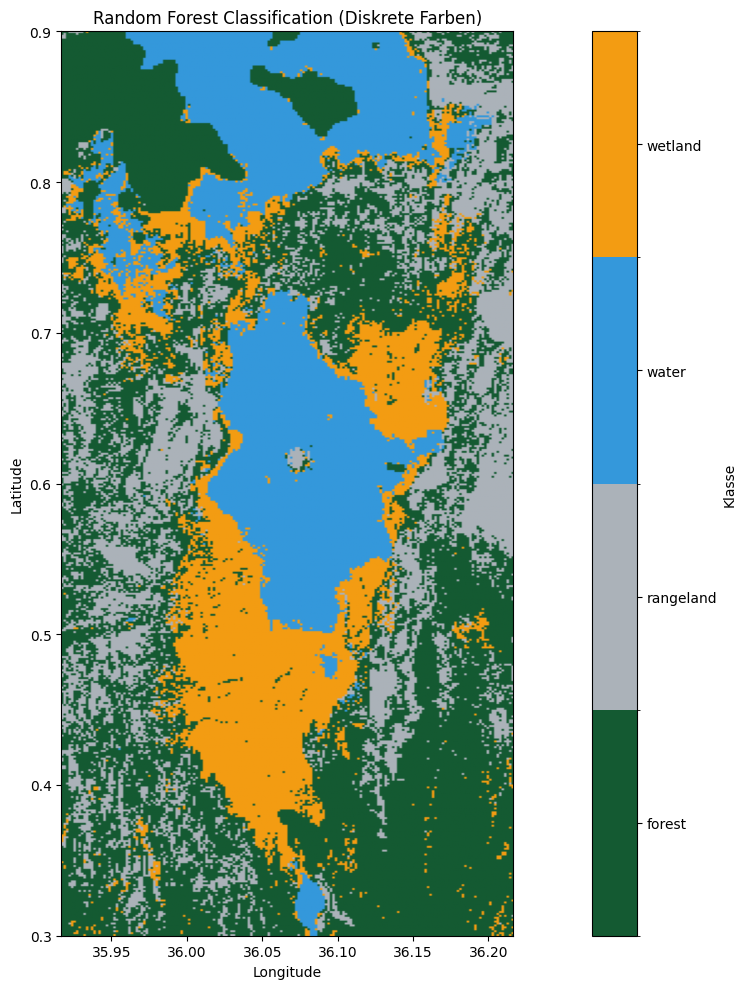

Flächen pro Klasse: 
forest: 83,312.62 ha (833,126,243 m²)
rangeland: 43,524.47 ha (435,244,654 m²)
wetland: 37,230.65 ha (372,306,454 m²)
water: 43,765.94 ha (437,659,362 m²)


In [70]:
# Klassenlabels aus LabelEncoder übernehmen (gleiche Reihenfolge)
class_labels = le.classes_

# Farben für jede Klasse zuweisen (ggf. Farbenliste erweitern)
colors = ['#145a32', '#abb2b9', '#3498db', '#f39c12']
cmap = ListedColormap(colors[:len(class_labels)])

# Normierung für diskrete Klassenfarben vorbereiten
bounds = np.arange(len(class_labels) + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

# Klassifizierte Karte plotten
plt.figure(figsize=(16, 10))
im = plt.imshow(
    predicted_img, 
    cmap=cmap, 
    norm=norm,
    extent=[extent[0], extent[2], extent[1], extent[3]], 
    origin='upper'
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random Forest Classification (Diskrete Farben)")
plt.gca().set_aspect('equal', adjustable='box')

# Individuelle Legende mit Klassenlabels
cbar = plt.colorbar(im, ticks=np.arange(len(class_labels)))
cbar.ax.set_yticklabels(class_labels)
cbar.set_label("Klasse")

plt.tight_layout()
plt.show()

# Ausgabe der Flächen je Klasse in Hektar und Quadratmetern
print("Flächen pro Klasse: ")
for class_name in class_areas_ha:
    print(f"{class_name}: {class_areas_ha[class_name]:,.2f} ha ({class_areas_m2[class_name]:,.0f} m²)")


#### 13. Wichtigkeit der Features

Die Bedeutung der Eingangsvariablen wird hier auf zwei Arten bewertet. Zunächst betrachten wir die Feature Importances, die während des Trainings des Random Forest berechnet werden. Sie geben an, wie stark ein Feature zur Trennung der Daten in den Entscheidungsbäumen beiträgt. Diese Werte können jedoch verzerrt sein, da Features mit vielen möglichen Aufteilungen (z. B. kontinuierliche Variablen mit großer Varianz) statistisch häufiger für Splits ausgewählt werden.

Aussagekräftiger ist deshalb die Permutation Importance: Dabei wird gemessen, wie stark sich das zufällige Vertauschen (Permutieren) der Werte eines Features auf die Vorhersagegenauigkeit auswirkt. Je stärker die Genauigkeit sinkt, desto wichtiger ist das Feature tatsächlich für das Modell.

Aus den Ergebnissen geht hervor, dass das DEM insgesamt die größte Bedeutung für die Klassifizierung hat, gefolgt von der Hangneigung und der LST. Die Klassensicht zeigt, dass insbesondere für rangeland alle drei Features eine positive Rolle spielen, während LST neben rangeland und forest eine Rolle spielt. Für die Klasse forest deuten die negativen Werte darauf hin, dass keines der betrachteten Features die Modellgüte für diese Klasse messbar verbessert.

Die Dynamik des Feuchtgebiets könnte in Zukunft jedoch gut mit den LST Daten beschrieben werden. DEM und Hangneigung sind statische Werte und verändern sich kaum. Die LST hingegen ist abhängig von den Temperaturen, der Transpiration der Vegetation sowie der Verdunstung von Wasser. Geringe Werte bei der Wichtigkeit der Features sollten deswegen kritisch betrachtet werden und als Anlass diese Dynamik in weiteren Notebooks zu testen.  

In [71]:
# Liste der Feature-Namen in der Reihenfolge des Trainings
feature_names = ["LST", "DEM", "SLOPE"]

# Feature-Importances aus dem Random Forest holen
importances = rf.feature_importances_

print("Feature Importances:\n")
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Klassenlabels aus LabelEncoder (muss mit Feature-Stack Reihenfolge übereinstimmen)
class_names = le.classes_

def class_wise_permutation_importance(model, X, y, feature_names, class_names):
    importances_per_class = []

    # Für jede Klasse separate binäre Zielvariable erzeugen und Permutations-Importance berechnen
    for class_idx, class_name in enumerate(class_names):
        y_binary = (y == class_idx).astype(int)
        
        result = permutation_importance(
            model, X, y_binary, n_repeats=100, random_state=42, n_jobs=-1
        )
        
        importances_per_class.append(result.importances_mean)

    # Ergebnis als DataFrame mit Klassen als Index und Features als Spalten
    df_importance = pd.DataFrame(importances_per_class, columns=feature_names, index=class_names)
    return df_importance

# Permutations-Importances je Klasse berechnen
importance_df = class_wise_permutation_importance(rf, X_train, y_train, feature_names, class_names)

print("\nFeature Importance per Class:\n")
print(importance_df.round(4))

Feature Importances:

LST: 0.2766
DEM: 0.4261
SLOPE: 0.2973



Feature Importance per Class:

              LST     DEM   SLOPE
forest    -0.0373 -0.0817 -0.0255
rangeland  0.0680  0.1772  0.0678
water     -0.0118  0.0585  0.0267
wetland   -0.0023  0.0528  0.0327
